In [68]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix, to_networkx
from torch_geometric.loader import NeighborLoader
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel
from tqdm import tqdm
import networkx as nx
import scipy.sparse as sp
import networkx as nx 
from torch_geometric.utils import subgraph
import torch.nn.utils.rnn as rnn_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim

In [69]:
# Check if CUDA is available and print the version of PyTorch and the device name 
# It will be useful to know if we are using a GPU or a CPU
import torch
print("Torch version:", torch.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
print("Is ROCm available:", torch.version.hip is not None)

Torch version: 2.5.1+rocm6.2
Is CUDA available: True
CUDA device name: Radeon RX 7900 XTX
Is ROCm available: True


<h3> Twitter dataset</h3>

In [70]:
# Load the data
df_parent = pd.read_csv('df_parent.csv', encoding='ISO-8859-15', lineterminator='\n')
# Preview the data
df_parent

,ID,text,label
0,731166399389962242,=%ca kkk grand wizard =% endorses @hillaryclin...,unverified
1,714598641827246081,an open letter to trump voters from his top st...,unverified
2,691809004356501505,america is a nation of second chances @potus ...,non-rumor
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true
...,...,...,...
2303,693546915892428800,jeb bush campaign kicks off 3-state farewell t...,non-rumor
2304,544269749405097984,breaking: live coverage of hostage situation u...,true
2305,760109079133990912,after school satan clubs ? URL,unverified
2306,779633844680962048,this network of tunnels is from the stone age ...,unverified


<h3> Propagation Dataset </h3>

<h3> Data Manipulation</h3>

In [71]:
# Load the child dataframe
df_child = pd.read_csv('df_child.csv')
# Display the first few rows of the dataframe
df_child

,file,parent_uid,parent_tid,parent_delay,child_uid,child_tid,child_delay
0,532602376398462976.txt,286742737,532602376398462976,0.00,2321563844,532602516014264320,0.55
1,532602376398462976.txt,286742737,532602376398462976,0.00,603800685,532602376398462976,27.58
2,532602376398462976.txt,286742737,532602376398462976,0.00,99739316,532602376398462976,27.58
3,532602376398462976.txt,286742737,532602376398462976,0.00,54023137,532602376398462976,27.58
4,532602376398462976.txt,286742737,532602376398462976,0.00,566709965,532602376398462976,27.58
...,...,...,...,...,...,...,...
957963,524969201102901248.txt,325326538,524969201102901248,78.93,303046775,524969201102901248,1029.78
957964,524969201102901248.txt,69460360,524969201102901248,9.27,325315594,524969201102901248,1033.33
957965,524969201102901248.txt,19636948,524969201102901248,0.00,2638326053,524969201102901248,1068.67
957966,524969201102901248.txt,19636948,524969201102901248,0.00,341822121,524969201102901248,1904.82


<h5> Parent </h5>

In [72]:
def clean_and_shorten_text(text):
    ''' Function to clean and shorten text and return the cleaned text
     Args:
        text: text to be cleaned  '''
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags (if any)
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Reconstruct split characters into proper words (e.g., "t h e" → "the")
    text = re.sub(r'\b(?:\w\s)+\w\b', lambda match: ''.join(match.group().split()), text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    # Remove the word "url" explicitly
    text = text.replace("url", "")  # Remove "url" word
    return text

In [73]:
# Apply the updated function to the dataset
df_parent['text_cleaned'] = df_parent['text'].apply(lambda x: clean_and_shorten_text(x))

# Preview the results
print(df_parent[['text', 'text_cleaned']].head())

                                                text  \
0  =%ca kkk grand wizard =% endorses @hillaryclin...   
1  an open letter to trump voters from his top st...   
2  america is a nation of second chances @potus ...   
3  brandon marshall visits and offers advice, sup...   
4  rip elly may clampett: so sad to learn #beverl...   

                                        text_cleaned  
0  ca kkk grand wizard endorses hillaryclinton ne...  
1  an open letter to trump voters from his top st...  
2  america is a nation of second chances potus on...  
3  brandon marshall visits and offers advice supp...  
4  rip elly may clampett so sad to learn beverlyh...  


In [74]:
# Create functions to extract hashtags and mentions
def extract_hashtags(text):
    ''' Extract hashtags from a text 
    Args:
        text (str): The input text'''
    
    hashtags = re.findall(r'#\w+', text) # Find all hashtags
    return " ".join(hashtags) if hashtags else "no hashtag" # Return the hashtags as a string or "no hashtag" if none


def extract_mentions(text):
    ''' Extract mentions from a text 
    Args:
        text (str): The input text'''
    
    mentions = re.findall(r'@(\w+)', text) # Find all mentions
    return " ".join(mentions) if mentions else "no mention" # Return the mentions as a string or "no mention" if none

# Apply the functions to the dataset
df_parent['hashtags'] = df_parent['text'].apply(extract_hashtags)
df_parent['mentions'] = df_parent['text'].apply(extract_mentions)
# Preview the results
df_parent

,ID,text,label,text_cleaned,hashtags,mentions
0,731166399389962242,=%ca kkk grand wizard =% endorses @hillaryclin...,unverified,ca kkk grand wizard endorses hillaryclinton ne...,#neverhillary #trump2016,hillaryclinton
1,714598641827246081,an open letter to trump voters from his top st...,unverified,an open letter to trump voters from his top st...,no hashtag,xojanedotcom
2,691809004356501505,america is a nation of second chances @potus ...,non-rumor,america is a nation of second chances potus on...,no hashtag,potus
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,brandon marshall visits and offers advice supp...,no hashtag,no mention
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,rip elly may clampett so sad to learn beverlyh...,#beverlyhillbillies,no mention
...,...,...,...,...,...,...
2303,693546915892428800,jeb bush campaign kicks off 3-state farewell t...,non-rumor,jeb bush campaign kicks off state farewell tou...,no hashtag,no mention
2304,544269749405097984,breaking: live coverage of hostage situation u...,true,breaking live coverage of hostage situation un...,no hashtag,no mention
2305,760109079133990912,after school satan clubs ? URL,unverified,after school satan clubs,no hashtag,no mention
2306,779633844680962048,this network of tunnels is from the stone age ...,unverified,this network of tunnels is from the stone age ...,no hashtag,no mention


In [75]:
# Drop the original text column after cleaning
df_parent.drop( labels= ['text'], inplace=True, axis=1)


In [76]:
# Initialize the Roberta sentiment analysis model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
# Load the pre-trained model and tokenizer 
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load the pre-trained model and tokenizer and move the model to the GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

In [77]:
def predict_sentiment(texts, tokenizer, model, batch_size=8, max_length=512):
    ''' Function to predict sentiment of texts using a pre-trained transformer model 
    Args:
        texts (list): List of texts to predict sentiment for
        tokenizer (transformers.PreTrainedTokenizer): Pre-trained tokenizer object
        model (transformers.PreTrainedModel): Pre-trained model object
        batch_size (int): Batch size for inference
        max_length (int): Maximum length of input sequence '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure the model is on the correct device (GPU or CPU)
    
    sentiment_classes = ["negative", "neutral", "positive"]  # Sentiment classes
    results = []  # To store results
    
    # Iterate over texts in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing Batches", unit="batch"):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize the batch of texts
        tokens = tokenizer(
            batch_texts,
            max_length=max_length,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(device)
        
        # Perform inference with no gradient calculation
        with torch.no_grad():
            outputs = model(**tokens)
            logits = outputs.logits
            
            # Apply softmax to get probabilities
            probs = torch.nn.functional.softmax(logits, dim=-1)
            
            # Get the sentiment class (max probability) and confidence
            sentiment_labels = torch.argmax(probs, dim=-1)
            confidences = torch.gather(probs, 1, sentiment_labels.unsqueeze(1)).squeeze()
        
        # Map results to sentiment class and confidence
        for label, confidence in zip(sentiment_labels, confidences):
            sentiment_class = sentiment_classes[label.item()]  # Get the corresponding sentiment class
            results.append(sentiment_class)
    
    return results

In [78]:
df_parent['text_cleaned'] = df_parent['text_cleaned'].astype(str)
df_parent['text_cleaned'] = df_parent['text_cleaned'].fillna("")
texts = df_parent['text_cleaned'].tolist()

df_parent['sentiment'] = predict_sentiment(texts, tokenizer, model)

df_parent

Processing Batches: 100%|██████████| 289/289 [00:01<00:00, 151.99batch/s]


,ID,label,text_cleaned,hashtags,mentions,sentiment
0,731166399389962242,unverified,ca kkk grand wizard endorses hillaryclinton ne...,#neverhillary #trump2016,hillaryclinton,neutral
1,714598641827246081,unverified,an open letter to trump voters from his top st...,no hashtag,xojanedotcom,neutral
2,691809004356501505,non-rumor,america is a nation of second chances potus on...,no hashtag,potus,neutral
3,693204708933160960,non-rumor,brandon marshall visits and offers advice supp...,no hashtag,no mention,neutral
4,551099691702956032,true,rip elly may clampett so sad to learn beverlyh...,#beverlyhillbillies,no mention,negative
...,...,...,...,...,...,...
2303,693546915892428800,non-rumor,jeb bush campaign kicks off state farewell tou...,no hashtag,no mention,neutral
2304,544269749405097984,true,breaking live coverage of hostage situation un...,no hashtag,no mention,neutral
2305,760109079133990912,unverified,after school satan clubs,no hashtag,no mention,neutral
2306,779633844680962048,unverified,this network of tunnels is from the stone age ...,no hashtag,no mention,neutral


In [79]:
# Initialize GPU device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load pre-trained BERT model and tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load pre-trained BERT model and move it to the GPU
model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [80]:
# Function to get BERT embeddings
def get_bert_embeddings(texts):
    ''' Function to get BERT embeddings for a list of texts 
    Args:
        texts: List of texts to get embeddings for 
        Returns: The embeddings for the input texts  '''
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  #Using GPU
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    return embeddings


In [81]:
# Get BERT embeddings for the cleaned text data in the parent dataset 
texts = df_parent['text_cleaned'].tolist() 
embeddings = get_bert_embeddings(texts) # Get BERT embeddings for the cleaned text data in the parent dataset

In [82]:
# Move back do CPU for visualization and further processing 
sentence_embeddings = embeddings.mean(dim=1).squeeze().cpu().numpy() 
# Add the embeddings to the DataFrame 
df_parent['bert_embeddings'] = list(sentence_embeddings)

# Preview the results
print(df_parent[['text_cleaned', 'bert_embeddings']].head())

                                        text_cleaned  \
0  ca kkk grand wizard endorses hillaryclinton ne...   
1  an open letter to trump voters from his top st...   
2  america is a nation of second chances potus on...   
3  brandon marshall visits and offers advice supp...   
4  rip elly may clampett so sad to learn beverlyh...   

                                     bert_embeddings  
0  [-0.09559602, -0.06573997, 0.60803634, 0.27787...  
1  [0.13298811, 0.10341653, 0.21683018, 0.4097066...  
2  [-0.06381727, -0.12853193, 0.2626873, 0.191746...  
3  [0.32737744, 0.23100159, 0.718798, 0.19795503,...  
4  [-0.13926572, 0.12236784, -0.045009457, 0.1170...  


In [83]:
# Drop the text_cleaned column after extracting the BERT embeddings
df_parent.drop(labels=['text_cleaned'], inplace = True , axis=1)
# Check the updated DataFrame
df_parent

,ID,label,hashtags,mentions,sentiment,bert_embeddings
0,731166399389962242,unverified,#neverhillary #trump2016,hillaryclinton,neutral,"[-0.09559602, -0.06573997, 0.60803634, 0.27787..."
1,714598641827246081,unverified,no hashtag,xojanedotcom,neutral,"[0.13298811, 0.10341653, 0.21683018, 0.4097066..."
2,691809004356501505,non-rumor,no hashtag,potus,neutral,"[-0.06381727, -0.12853193, 0.2626873, 0.191746..."
3,693204708933160960,non-rumor,no hashtag,no mention,neutral,"[0.32737744, 0.23100159, 0.718798, 0.19795503,..."
4,551099691702956032,true,#beverlyhillbillies,no mention,negative,"[-0.13926572, 0.12236784, -0.045009457, 0.1170..."
...,...,...,...,...,...,...
2303,693546915892428800,non-rumor,no hashtag,no mention,neutral,"[-0.11719457, -0.11156258, 0.39902538, 0.07430..."
2304,544269749405097984,true,no hashtag,no mention,neutral,"[0.005820112, -0.3875105, 0.12805948, -0.05350..."
2305,760109079133990912,unverified,no hashtag,no mention,neutral,"[0.074415945, -0.17128468, 0.5480159, 0.051338..."
2306,779633844680962048,unverified,no hashtag,no mention,neutral,"[0.115285404, 0.078219846, 0.3658323, 0.201319..."


In [84]:
# Check label distribution
df_parent['label'].value_counts()

non-rumor     579
true          579
unverified    575
false         575
Name: label, dtype: int64

In [85]:
# Label encoders for the sentiment and label columns
sentiment_encoder = LabelEncoder()
label_encoder = LabelEncoder()

df_parent["encoded_sentiment"] = sentiment_encoder.fit_transform(df_parent["sentiment"])
df_parent["encoded_label"] = label_encoder.fit_transform(df_parent["label"])

In [86]:
# Group and aggregate child metadata by parent ID 
child_metadata = df_child.groupby('parent_tid').agg(
    interaction_count=('child_uid', 'count'), # Number of interactions
    avg_interaction_time =('child_delay', 'mean'), # Average interaction time
    avg_publisher_time=('parent_delay', 'mean'), # Average publisher time
).reset_index() # Reset the index

# Merge the metadata into the parent DataFrame
df_parent = df_parent.merge(
    child_metadata, # Merge with the aggregated child metadata
    how="left", # Perform a left join
    left_on="ID", # Use the 'ID' column from the parent DataFrame
    right_on="parent_tid" # Use the 'parent_tid' column from the child metadata
)

# Drop the redundant 'parent_tid' column
df_parent = df_parent.drop(columns=['parent_tid'])
# Check shape and preview the DataFrame
print(df_parent.shape)
df_parent.head(2)

(2308, 11)


,ID,label,hashtags,mentions,sentiment,bert_embeddings,encoded_sentiment,encoded_label,interaction_count,avg_interaction_time,avg_publisher_time
0,731166399389962242,unverified,#neverhillary #trump2016,hillaryclinton,neutral,"[-0.09559602, -0.06573997, 0.60803634, 0.27787...",1,3,290,14869.900345,41.624414
1,714598641827246081,unverified,no hashtag,xojanedotcom,neutral,"[0.13298811, 0.10341653, 0.21683018, 0.4097066...",1,3,188,1485.355638,72.125319


In [87]:
# Count hashtags in the text column of the parent DataFrame and append the count as a new column
df_parent["hashtag_count"] = df_parent["hashtags"].apply(lambda x: len(x.split()) if x != "no hashtag" else 0)

# Count mentions in the text column of the parent DataFrame and append the count as a new column
df_parent["mention_count"] = df_parent["mentions"].apply(lambda x: len(x.split()) if x != "no mention" else 0)

# Check the updated DataFrame with the new columns
df_parent

,ID,label,hashtags,mentions,sentiment,bert_embeddings,encoded_sentiment,encoded_label,interaction_count,avg_interaction_time,avg_publisher_time,hashtag_count,mention_count
0,731166399389962242,unverified,#neverhillary #trump2016,hillaryclinton,neutral,"[-0.09559602, -0.06573997, 0.60803634, 0.27787...",1,3,290,14869.900345,41.624414,2,1
1,714598641827246081,unverified,no hashtag,xojanedotcom,neutral,"[0.13298811, 0.10341653, 0.21683018, 0.4097066...",1,3,188,1485.355638,72.125319,0,1
2,691809004356501505,non-rumor,no hashtag,potus,neutral,"[-0.06381727, -0.12853193, 0.2626873, 0.191746...",1,1,629,900.127234,40.678347,0,1
3,693204708933160960,non-rumor,no hashtag,no mention,neutral,"[0.32737744, 0.23100159, 0.718798, 0.19795503,...",1,1,324,758.480123,91.728580,0,0
4,551099691702956032,true,#beverlyhillbillies,no mention,negative,"[-0.13926572, 0.12236784, -0.045009457, 0.1170...",0,2,116,33.907759,0.445000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,693546915892428800,non-rumor,no hashtag,no mention,neutral,"[-0.11719457, -0.11156258, 0.39902538, 0.07430...",1,1,289,626.303806,14.393772,0,0
2304,544269749405097984,true,no hashtag,no mention,neutral,"[0.005820112, -0.3875105, 0.12805948, -0.05350...",1,2,441,64.466871,5.784422,0,0
2305,760109079133990912,unverified,no hashtag,no mention,neutral,"[0.074415945, -0.17128468, 0.5480159, 0.051338...",1,3,294,652.671156,0.137687,0,0
2306,779633844680962048,unverified,no hashtag,no mention,neutral,"[0.115285404, 0.078219846, 0.3658323, 0.201319...",1,3,472,5799.563326,282.490890,0,0


In [88]:
# Select the relevant columns for the final parent dataset
df_parent_clean = df_parent[["ID", 'interaction_count' ,'avg_interaction_time', 'avg_publisher_time',"encoded_sentiment", "hashtag_count", "mention_count", 'bert_embeddings', "encoded_label"]]
df_parent_clean # Check the final parent dataset

,ID,interaction_count,avg_interaction_time,avg_publisher_time,encoded_sentiment,hashtag_count,mention_count,bert_embeddings,encoded_label
0,731166399389962242,290,14869.900345,41.624414,1,2,1,"[-0.09559602, -0.06573997, 0.60803634, 0.27787...",3
1,714598641827246081,188,1485.355638,72.125319,1,0,1,"[0.13298811, 0.10341653, 0.21683018, 0.4097066...",3
2,691809004356501505,629,900.127234,40.678347,1,0,1,"[-0.06381727, -0.12853193, 0.2626873, 0.191746...",1
3,693204708933160960,324,758.480123,91.728580,1,0,0,"[0.32737744, 0.23100159, 0.718798, 0.19795503,...",1
4,551099691702956032,116,33.907759,0.445000,0,1,0,"[-0.13926572, 0.12236784, -0.045009457, 0.1170...",2
...,...,...,...,...,...,...,...,...,...
2303,693546915892428800,289,626.303806,14.393772,1,0,0,"[-0.11719457, -0.11156258, 0.39902538, 0.07430...",1
2304,544269749405097984,441,64.466871,5.784422,1,0,0,"[0.005820112, -0.3875105, 0.12805948, -0.05350...",2
2305,760109079133990912,294,652.671156,0.137687,1,0,0,"[0.074415945, -0.17128468, 0.5480159, 0.051338...",3
2306,779633844680962048,472,5799.563326,282.490890,1,0,0,"[0.115285404, 0.078219846, 0.3658323, 0.201319...",3


<h3> Node selection </h3>

In [89]:
# Check child DataFrame
df_child

,file,parent_uid,parent_tid,parent_delay,child_uid,child_tid,child_delay
0,532602376398462976.txt,286742737,532602376398462976,0.00,2321563844,532602516014264320,0.55
1,532602376398462976.txt,286742737,532602376398462976,0.00,603800685,532602376398462976,27.58
2,532602376398462976.txt,286742737,532602376398462976,0.00,99739316,532602376398462976,27.58
3,532602376398462976.txt,286742737,532602376398462976,0.00,54023137,532602376398462976,27.58
4,532602376398462976.txt,286742737,532602376398462976,0.00,566709965,532602376398462976,27.58
...,...,...,...,...,...,...,...
957963,524969201102901248.txt,325326538,524969201102901248,78.93,303046775,524969201102901248,1029.78
957964,524969201102901248.txt,69460360,524969201102901248,9.27,325315594,524969201102901248,1033.33
957965,524969201102901248.txt,19636948,524969201102901248,0.00,2638326053,524969201102901248,1068.67
957966,524969201102901248.txt,19636948,524969201102901248,0.00,341822121,524969201102901248,1904.82


In [90]:
# Initialize the data object
data = Data()

<H5> Feature Engineering </h5>

In [91]:
# Map tweet IDs to node indices (starting from 0) for parent tweets
tweet_to_idx = {tid: idx for idx, tid in enumerate(df_parent_clean['ID'])}

# Map all user IDs to node indices
all_user_ids = set(df_child['parent_uid'].unique()).union(set(df_child['child_uid'].unique()))
user_to_idx = {uid: idx + len(tweet_to_idx) for idx, uid in enumerate(all_user_ids)} # Start from the last tweet index + 1 for users 

num_tweets = len(tweet_to_idx) # Number of unique tweets
num_users = len(user_to_idx) # Number of unique users
num_nodes = num_tweets + num_users # Total number of nodes

# Print the number of unique tweets, users, and total nodes
print(f"Number of unique tweets: {num_tweets}")
print(f"Number of unique users (parent + child): {num_users}")
print(f"Total number of nodes: {num_nodes}")

Number of unique tweets: 2139
Number of unique users (parent + child): 677640
Total number of nodes: 679779


In [92]:
#Tweet to commenters (child_uid) edges 
tweet_user_edges = [
    (tweet_to_idx[row['parent_tid']], user_to_idx[row['parent_uid']]) # (source, target) 
    for _, row in df_child.drop_duplicates(subset=['parent_tid', 'parent_uid']).iterrows() # Drop duplicates 
    if row['parent_tid'] in tweet_to_idx and row['parent_uid'] in user_to_idx # Check if the tweet and user exist in the dictionaries
]

# Tweet to commenters (child_uid) edges 
tweet_comment_edges = [
    (tweet_to_idx[row['parent_tid']], user_to_idx[row['child_uid']]) # (source, target)
    for _, row in df_child.drop_duplicates(subset=['parent_tid', 'child_uid']).iterrows() # Drop duplicates 
    if row['parent_tid'] in tweet_to_idx and row['child_uid'] in user_to_idx # Check if the tweet and user exist in the dictionaries
]

# User-to-User (parent_uid to child_uid) edges
user_user_edges = [
    (user_to_idx[row['parent_uid']], user_to_idx[row['child_uid']]) # (source, target)
    for _, row in df_child.drop_duplicates(subset=['parent_uid', 'child_uid']).iterrows() # Drop duplicates
    if row['parent_uid'] in user_to_idx and row['child_uid'] in user_to_idx # Check if the users exist in the dictionaries
]

# Combine all edges into a single NumPy array
edges = np.array(tweet_user_edges + tweet_comment_edges + user_user_edges)

# Print the shape of the edges array
print(f"Edges shape: {edges.shape}")

Edges shape: (1800637, 2)


In [93]:
# Bert embeddings for tweets text
bert_embeddings = np.array(df_parent_clean['bert_embeddings'].tolist()) # Convert to numpy array 
bert_embeddings = torch.tensor(bert_embeddings, dtype=torch.float) # Convert to PyTorch tensor 

# Scale extra features
scaler = StandardScaler()
extra_features = torch.tensor(
    scaler.fit_transform(df_parent_clean[['interaction_count', 'avg_interaction_time', 'avg_publisher_time',
                                          'encoded_sentiment', 'hashtag_count', 'mention_count']].values),
    dtype=torch.float
)

# Concatenate tweet features (BERT embeddings + extra features)
tweet_features = torch.cat((bert_embeddings, extra_features), dim=1) #dim=1 for concatenation along columns 

# User features derived from delays
df_child['scaled_child_delay'] = scaler.fit_transform(df_child[['child_delay']]) # Scale child delays
df_child['scaled_parent_delay'] = scaler.fit_transform(df_child[['parent_delay']]) # Scale parent delays

# Aggregate delays for each user (parent_uid and child_uid)
child_uid_to_delay = df_child.groupby("child_uid")['scaled_child_delay'].mean()
parent_uid_to_delay = df_child.groupby("parent_uid")['scaled_parent_delay'].mean()

# Merge delays and combine them into a single feature
all_user_delays = pd.concat([child_uid_to_delay, parent_uid_to_delay], axis=1, keys=['child_delay', 'parent_delay']).fillna(0)
all_user_delays['combined_delay'] = all_user_delays.mean(axis=1)
user_uid_to_delay = all_user_delays['combined_delay'].reindex(user_to_idx.keys(), fill_value=0).to_dict()


# User features derived from delays (parent_uid and child_uid)
user_features = torch.tensor(
    [user_uid_to_delay.get(uid, 0) for uid in user_to_idx.keys()], # Get the delay for each user from the dictionary 
    dtype=torch.float
).view(-1, 1)


In [94]:
# Check the shapes of the tweet and user features
if user_features.size(1) < tweet_features.size(1): # Check if user features have fewer columns than tweet features
    padding = tweet_features.size(1) - user_features.size(1) # Calculate the padding required
    user_features = torch.cat([user_features, torch.zeros((len(user_features), padding))], dim=1) # Pad the user features
elif user_features.size(1) > tweet_features.size(1): # Check if user features have more columns than tweet features
    padding = user_features.size(1) - tweet_features.size(1) # Calculate the padding required
    tweet_features = torch.cat([tweet_features, torch.zeros((len(tweet_features), padding))], dim=1) # Pad the tweet features

# Initialize node feature matrix
x = torch.zeros((num_nodes, tweet_features.size(1)), dtype=torch.float)

# Populate `x` with tweet features
for tid, idx in tweet_to_idx.items():
    row_indices = df_parent_clean.index[df_parent_clean['ID'] == tid].tolist()
    if row_indices:
        row_index = row_indices[0]
        if 0 <= row_index < tweet_features.size(0):
            x[idx] = tweet_features[row_index]

# Populate `x` with user features
for uid, idx in user_to_idx.items():
    if 0 <= idx - num_tweets < user_features.size(0):  # Correct indexing for users
        x[idx] = user_features[idx - num_tweets]

print(f"x shape: {x.shape}")
print(f"Non-zero rows in x: {x.sum(dim=1).nonzero().size(0)}")
print(f"Tweet feature coverage: {len(tweet_to_idx)} rows mapped")
print(f"User feature coverage: {len(user_to_idx)} rows mapped")


x shape: torch.Size([679779, 774])
Non-zero rows in x: 679610
Tweet feature coverage: 2139 rows mapped
User feature coverage: 677640 rows mapped


<h5> Adjacency Matrix </h5>

In [95]:
# User features (delay) for each user node in the graph
num_tweets = tweet_features.size(0) # Number of tweet nodes
num_users = user_features.size(0) # Number of user nodes

# Initialize user features with delay values for each user
if user_features.size(1) < tweet_features.size(1): # If user features have fewer columns than tweet features 
    padding = tweet_features.size(1) - user_features.size(1) # Calculate the padding required to match the columns size
    user_features = torch.cat([user_features, torch.zeros((num_users, padding))], dim=1) # Pad the user features with zeros to match the columns size of tweet features

# Concatenate tweet and user features to form the node feature matrix   
all_features = torch.cat([tweet_features, user_features], dim=0).numpy()

In [96]:
# Convert features to PyTorch tensors
features_tensor = torch.tensor(all_features, dtype=torch.float)

# Normalize features for cosine similarity
features_tensor = F.normalize(features_tensor, p=2, dim=1)

# Compute pairwise cosine similarity only for edges
edge_weights = []
# Compute edge weights based on cosine similarity 
for src, dest in edges: # Iterate over source and destination nodes
    similarity = (1 + (features_tensor[src] @ features_tensor[dest]).item()) / 2  # Compute cosine similarity and scale to [0, 1]
    edge_weights.append(similarity)
 
# Convert edge weights to PyTorch tensor
weights = torch.tensor(edge_weights, dtype=torch.float) 

# Print the shape of the edge weights
print(f"Edge weights computed: {weights.shape}")

Edge weights computed: torch.Size([1800637])


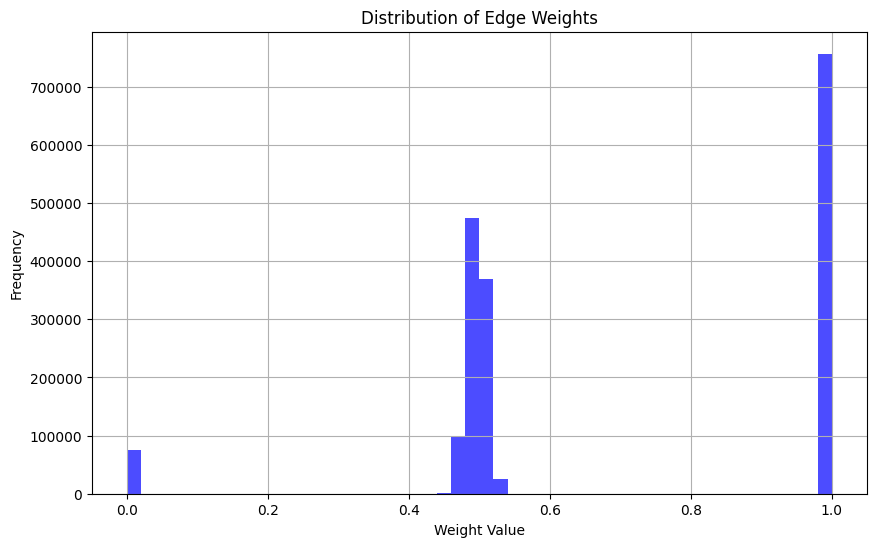

In [97]:
# Plot the histogram of weights
plt.figure(figsize=(10, 6))
plt.hist(weights, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Edge Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [98]:
# Check for zero weights (sparsity)
non_zero_weights = np.count_nonzero(weights)
total_weights = len(weights)
sparsity =  1 - non_zero_weights / total_weights

# Display sparsity information
print(f"Number of Non-Zero Weights: {non_zero_weights}")
print(f"Total Number of Weights: {total_weights}")
print(f"Sparsity: {sparsity:.4f}")

Number of Non-Zero Weights: 1725867
Total Number of Weights: 1800637
Sparsity: 0.0415


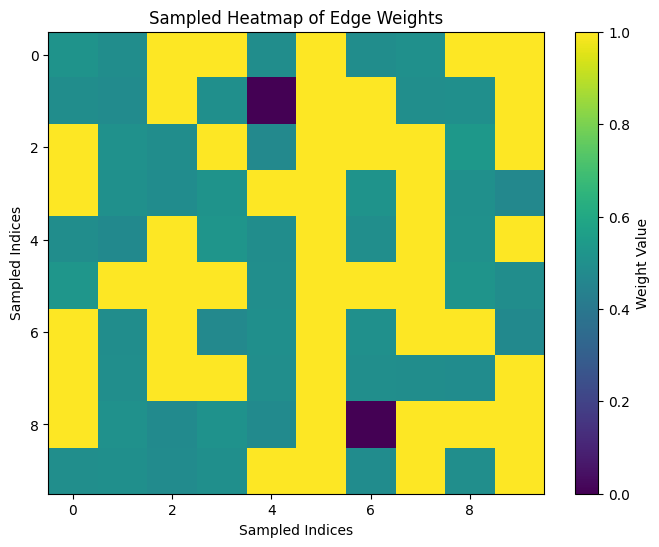

In [99]:
# Create a Sampled Heatmap of Edge Weights to visualize the distribution
sampled_indices = np.random.choice(len(weights), size=100, replace=False) # Sample 100 indices
sampled_weights = weights[sampled_indices] # Get the corresponding weights
# Plot the heatmap
plt.figure(figsize=(8, 6)) 
plt.imshow(sampled_weights.reshape((10, 10)), cmap='viridis', aspect='auto')
plt.colorbar(label="Weight Value")
plt.title("Sampled Heatmap of Edge Weights")
plt.xlabel("Sampled Indices")
plt.ylabel("Sampled Indices")
plt.show()

<h5> Build a Adjacency Matrix </h5>

In [100]:
# Build the symmetric adjacency matrix
def build_symmetric_adjacency_matrix(edges, weights, num_nodes):
    ''' Function to build a fully symmetric adjacency matrix for the graph using the edge weights and indices of the edges
     Reference:
    - Adapted from OwenLeng's rumor-detection repository (Twitter15 & Twitter16 dataset)
    - GitHub: https://github.com/OwenLeng/rumor-detection-include-twitter15-twitter16data-/blob/master/dataset/preprocess.py
    args:
        edges: indices of the edges
        weights: edge weights
        num_nodes: number of nodes in the graph
    returns:
        adj: the symmetric adjacency matrix '''

    def normalize_adj(mx): 
        """Row-normalize sparse matrix"""
        rowsum = np.array(mx.sum(1)).flatten() # Sum the rows of the matrix and flatten the array to 1D
        r_inv_sqrt = np.power(rowsum, -0.5, where=rowsum > 0) # Compute the inverse square root of the row sums (ignoring divide by zero)
        r_mat_inv_sqrt = sp.diags(r_inv_sqrt) # Create a sparse diagonal matrix from the row sums inverse square root values 
        return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt) # Return the normalized matrix using the row sums inverse square root values 

    # Create the sparse adjacency matrix using weights 
    adj = sp.coo_matrix((weights, (edges[:, 0], edges[:, 1])), shape=(num_nodes, num_nodes), dtype=np.float32)
    
    # Symmetrize the adjacency matrix 
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    
    # Normalize and add self-loops
    adj = normalize_adj(adj + sp.eye(adj.shape[0]))
    return adj.tocoo() # Return the matrix in COO format 

In [101]:
# Build adjacency matrix
num_nodes = num_tweets + num_users # Total number of nodes
weights = weights  # Edge weights computed
edges = edges # Edge indices (source and destination nodes)
adj = build_symmetric_adjacency_matrix(edges, weights, num_nodes) # Build the adjacency matrix 

edge_index, edge_attr = from_scipy_sparse_matrix(adj) # Convert the adjacency matrix to edge indices and edge attributes

# Print the shapes of the edge index and edge attribute tensors
print(f"Edge index shape: {edge_index.shape}") 
print(f"Edge attribute shape: {edge_attr.shape}")


Edge index shape: torch.Size([2, 3947156])
Edge attribute shape: torch.Size([3947156])


<h5> Building the Graph  </h5>

In [102]:
# Create labels tensor (default to -1 for user nodes)
y = torch.full((x.size(0),), -1, dtype=torch.long) 

# Assign labels for tweet nodes
y[:len(tweet_features)] = torch.tensor(
    df_parent_clean['encoded_label'].values,
    dtype=torch.long
)

# Display the shape of the labels tensor
print(f"y shape: {y.shape}")

y shape: torch.Size([679779])


In [103]:
# Create the PyG graph data object
data = Data( 
    x=x,                   # Node feature matrix
    edge_index=edge_index, # Edge indices
    edge_attr=edge_attr,   # Edge weights
    y=y,                   # Node labels
)

# Display the data object
print(data)

Data(x=[679779, 774], edge_index=[2, 3947156], edge_attr=[3947156], y=[679779])


In [104]:
G = to_networkx(data, to_undirected=True)

# Define the label mapping
label_mapping = {-1: "user", 0: "unverified", 1: "non-rumor", 2: "true", 3: "false"}

# Assign labels to the nodes in the graph based on 'y'
for i, label in enumerate(data.y):
    # Map the label in 'y' to the corresponding label name
    label_name = label_mapping.get(label.item(), None)  # Default to None if no match found
    if label_name is not None:
        G.nodes[i]['label'] = label_name

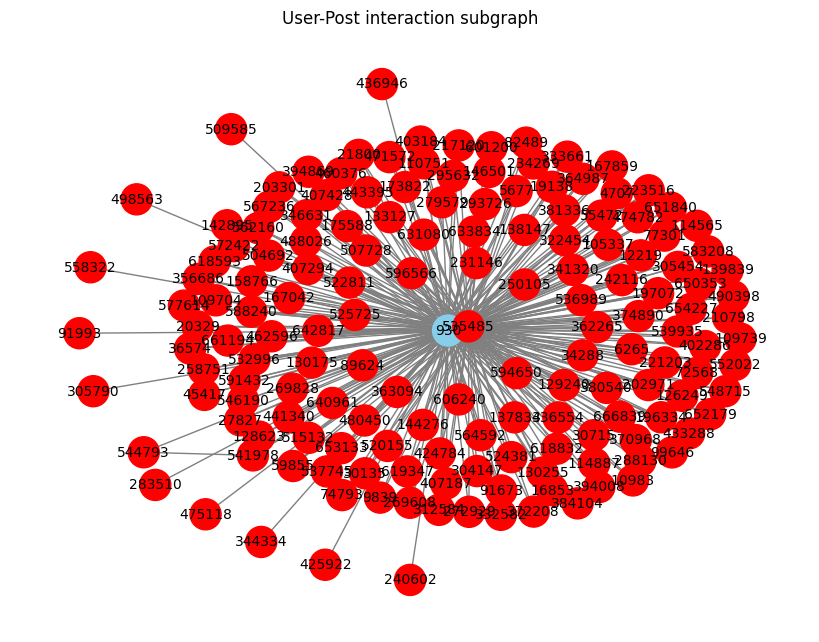

In [105]:

# Select nodes with valid labels (excluding "user")
valid_labels = ["unverified", "non-rumor", "true", "false"]
valid_nodes = [node for node, attr in G.nodes(data=True) if attr.get('label') in valid_labels]

# Randomly select 3 nodes with valid labels (excluding "user")
num_nodes = 1
random_nodes = random.sample(valid_nodes, num_nodes)

# Get the neighbors of the selected nodes, including the itself
nodes_with_neighbors = set(random_nodes)
for node in random_nodes:
    neighbors = list(G.neighbors(node))
    nodes_with_neighbors.update(neighbors)

# Subgraph with the selected nodes and their neighbors
subgraph = G.subgraph(nodes_with_neighbors).copy()  # Make a copy of the subgraph

# Remove self-loops from the subgraph for better visualization
subgraph.remove_edges_from(nx.selfloop_edges(subgraph))

# Plot the subgraph without self-loops
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(subgraph, seed=42)  # Layout for visualization
node_colors = ['red' if G.nodes[n]['label'] == "user" else 'skyblue' for n in subgraph.nodes()] # Red for users, blue for tweets

# Draw the subgraph
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=500, font_size=10)
plt.title("User-Post interaction subgraph")
plt.show()

<h5> Train/Test/Valid split </5>

In [106]:
data

Data(x=[679779, 774], edge_index=[2, 3947156], edge_attr=[3947156], y=[679779])

In [107]:
# Split the dataset into train, validation, and test sets

labeled_nodes = torch.where(data.y != -1)[0] #all the labeled nodes only 
labels = data.y[labeled_nodes].cpu().numpy()  # Get their corresponding labels

train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    labeled_nodes.cpu().numpy(), labels,  # Nodes & labels
    test_size=0.2,  # 80% train, 20% temp (val + test)
    random_state=33,
    stratify=labels  #Ensures balanced class distribution
)

# Split the test set into validation and test sets (50% each)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=33, stratify=labels[temp_idx])

# Create masks for the train, validation, and test sets (True for nodes that are part of the set)
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool) # Create a train mask of all False values
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool) # Create a validation mask of all False values
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool) # Create a test mask of all False values

train_mask[train_idx] = True # Set the indices of the train nodes to True 
val_mask[val_idx] = True # Set the indices of the validation nodes to True
test_mask[test_idx] = True # Set the indices of the test nodes to True

# Assign masks to the `data` object
data.train_mask = train_mask # Assign the train mask to the `train_mask` attribute of the `data` object
data.val_mask = val_mask # Assign the validation mask to the `val_mask` attribute of the `data` object
data.test_mask = test_mask # Assign the test mask to the `test_mask` attribute of the `data` object

print(f"Train Mask Coverage: {train_mask.sum()} nodes") # Print the number of nodes in the train mask
print(f"Validation Mask Coverage: {val_mask.sum()} nodes") # Print the number of nodes in the validation mask
print(f"Test Mask Coverage: {test_mask.sum()} nodes") # Print the number of nodes in the test mask

Train Mask Coverage: 1846 nodes
Validation Mask Coverage: 231 nodes
Test Mask Coverage: 231 nodes


<h5> GNNS </5>

<h6> GCN </6>

In [108]:
class SimpleGCN(nn.Module):  
    """  
    Simple Graph Convolutional Network (GCN) Model.  

    This implementation is adapted from Thomas Kipf's PyTorch GCN implementation:  
    GitHub: https://github.com/tkipf/pygcn  
    Original Paper:  
    Kipf, T. N., & Welling, M. (2017). "Semi-Supervised Classification with Graph Convolutional Networks."  
    arXiv preprint arXiv:1609.02907. (https://arxiv.org/abs/1609.02907)  

    Args:  
        in_channels (int): Number of input features per node.  
        hidden_channels (int): Number of hidden layer features.  
        out_channels (int): Number of output classes.  
    """  
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):  
        super(SimpleGCN, self).__init__()  
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

 # Forward pass function 
    def forward(self, x, edge_index): 
        # First GCN Layer 
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Non-linear activation
        x = F.dropout(x, p=0.5, training=self.training)  # Regularization

        # Second GCN Layer
        x = self.conv2(x, edge_index) # Second GCN layer
        return F.log_softmax(x, dim=1)  # Softmax activation function for classification 

In [109]:
# Initialize the GCN model
in_channels = data.x.size(1)  # Number of features per node
hidden_channels = 128  # Hidden dimension size
out_channels = torch.unique(data.y[data.y != -1]).size(0)  # Number of unique classes (excluding -1 for unlabeled nodes)

# Initialize the GCN model
GCN = SimpleGCN(in_channels, hidden_channels, out_channels).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(GCN.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss() # Cross-entropy loss for classification tasks   

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data.x = data.x.to('cuda')
data.edge_index = data.edge_index.to('cuda')
data.y = data.y.to('cuda')  # Move all labels to CUDA
tweet_mask = (data.y != -1)  # Create a mask to exclude -1 labels



In [110]:
# Neighbor loader for training and validation
train_loader = NeighborLoader(
    data,  # The graph data object
    num_neighbors=[15, 10],  # Number of neighbors to sample in each layer
    batch_size=256,  # Batch size 
    input_nodes=data.train_mask # Only nodes with `train_mask=True` will be considered as input nodes
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[15, 10],
    batch_size=256,
    input_nodes=data.test_mask.nonzero().squeeze(),  # use the test nodes
    shuffle=False  # Do not shuffle the test nodes
)


val_loader = NeighborLoader(
    data,
    num_neighbors=[15, 10],
    batch_size=256,
    input_nodes=data.val_mask
)

/home/gigli/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning:

Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling



In [111]:
# Training loop
best_val_acc = 0.0  
best_model = None   

for epoch in range(100):  
    GCN.train()
    total_loss = 0  

    # Run the training loop
    for batch in train_loader:
        batch = batch.to(device)  # Move batch to GPU

        optimizer.zero_grad()  

        # Forward pass (only on batch, not full graph)
        out = GCN(batch.x, batch.edge_index)  

        # 
        loss = loss_fn(out[batch.train_mask], batch.y[batch.train_mask])  
        loss.backward()  
        optimizer.step()  

        total_loss += loss.item()  

    # Run the validation loop
    GCN.eval()
    with torch.no_grad(): # no gradient computation for validation
        val_correct = 0
        val_total = 0
        val_loss_total = 0
        
        for batch in val_loader:
            batch = batch.to(device)
            out = GCN(batch.x, batch.edge_index)
            val_loss = loss_fn(out[batch.val_mask], batch.y[batch.val_mask])
            val_pred = out[batch.val_mask].argmax(dim=1)
            val_correct += (val_pred == batch.y[batch.val_mask]).sum().item()
            val_total += batch.val_mask.sum().item()
            val_loss_total += val_loss.item()

        # calculate validation accuracy
        val_acc = val_correct / val_total if val_total > 0 else 0
        avg_val_loss = val_loss_total / len(val_loader)
        # Track best model 
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = GCN.state_dict()
    # Print the epoch, total loss, validation loss, and validation accuracy throughout training        
    print(f"Epoch {epoch + 1:03d}, Loss: {total_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

# print the best validation accuracy
print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")


Epoch 001, Loss: 10.9775, Val Loss: 1.3037, Val Acc: 0.3333
Epoch 002, Loss: 9.6314, Val Loss: 1.2355, Val Acc: 0.4502
Epoch 003, Loss: 8.8600, Val Loss: 1.1900, Val Acc: 0.5065
Epoch 004, Loss: 8.2837, Val Loss: 1.1499, Val Acc: 0.5455
Epoch 005, Loss: 7.8013, Val Loss: 1.1203, Val Acc: 0.5801
Epoch 006, Loss: 7.3079, Val Loss: 1.0914, Val Acc: 0.5628
Epoch 007, Loss: 6.9535, Val Loss: 1.0815, Val Acc: 0.6061
Epoch 008, Loss: 6.6000, Val Loss: 1.0362, Val Acc: 0.6277
Epoch 009, Loss: 6.3468, Val Loss: 1.0296, Val Acc: 0.6147
Epoch 010, Loss: 6.0562, Val Loss: 1.0071, Val Acc: 0.6061
Epoch 011, Loss: 5.7602, Val Loss: 0.9913, Val Acc: 0.6104
Epoch 012, Loss: 5.4554, Val Loss: 0.9931, Val Acc: 0.6017
Epoch 013, Loss: 5.3406, Val Loss: 0.9588, Val Acc: 0.6364
Epoch 014, Loss: 5.0790, Val Loss: 0.9576, Val Acc: 0.6277
Epoch 015, Loss: 4.9378, Val Loss: 0.9650, Val Acc: 0.6623
Epoch 016, Loss: 4.7746, Val Loss: 0.9459, Val Acc: 0.6710
Epoch 017, Loss: 4.4880, Val Loss: 0.9107, Val Acc: 0.7

In [138]:
GCN.eval()
y_test_true = []
y_test_pred = []

with torch.no_grad():  
    for batch in test_loader:  # =
        batch = batch.to(device)  # Move batch to GPU
        
        # Forward pass for batch
        out = GCN(batch.x, batch.edge_index)

        # ✅ Mask for labeled test nodes only
        mask = (batch.test_mask == True) & (batch.y != -1)

        if mask.sum().item() > 0:  # 
            y_test_true.append(batch.y[mask].cpu().to(torch.int64))
            y_test_pred.append(out[mask].argmax(dim=1).cpu().to(torch.int64))

# 
y_test_true = torch.cat(y_test_true)
y_test_pred = torch.cat(y_test_pred)

# 
test_acc = accuracy_score(y_test_true, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7662


Classification Report:

              precision    recall  f1-score   support

       false       0.79      0.64      0.70        58
   non-rumor       0.82      0.84      0.83        58
        true       0.76      0.91      0.83        58
  unverified       0.70      0.67      0.68        57

    accuracy                           0.77       231
   macro avg       0.77      0.77      0.76       231
weighted avg       0.77      0.77      0.76       231



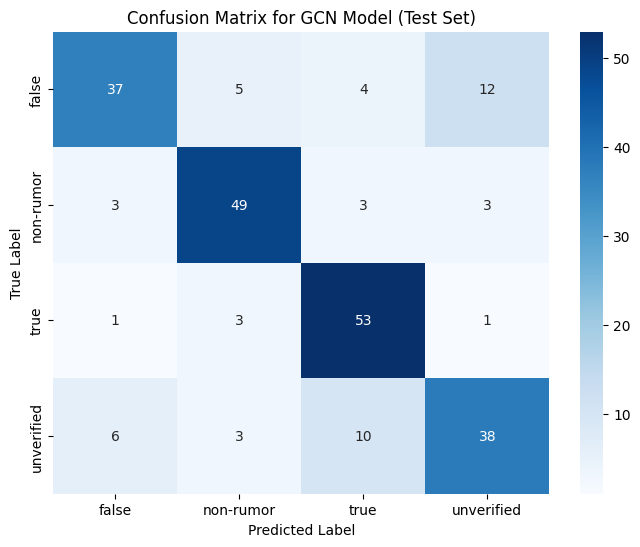

In [139]:

# Convert numeric labels back to original text labels
y_test_true_names = label_encoder.inverse_transform(y_test_true.numpy())  
y_test_pred_names = label_encoder.inverse_transform(y_test_pred.numpy()) 


print("Classification Report:\n")
print(classification_report(y_test_true_names, y_test_pred_names))


# Convert numeric labels back to original text labels
y_test_true_names = label_encoder.inverse_transform(y_test_true.numpy())  
y_test_pred_names = label_encoder.inverse_transform(y_test_pred.numpy())  

conf_matrix = confusion_matrix(y_test_true_names, y_test_pred_names)  # Compute confusion matrix
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for GCN Model (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

<h3> GCN Transformer </h3>

In [114]:
class TransformerLayer(nn.Module): #Transformer Layer
    
    '''
     Reference: This implementation follows the structure of Transformer layers as described in the PyTorch official documentation (PyTorch, 2024).
       Create 2 layers for the Transformer model:
    1st: Multi-head Attention: Used for self-attention mechanism and capturing relationships between nodes. Very useful for sparse graphs.
    2st Feedfoward Network: Used to apply non-linear transformations to the input features. Very useful for learning complex patterns in the data.
    Inputs:
    embed_dim: Embedding dimension
    num_heads: Number of heads for multi-head attention
    ff_hidden_dim: Feedforward hidden dimension
    dropout: Dropout rate for regularization
    '''

    def __init__(self, embed_dim, num_heads, ff_hidden_dim, dropout=0.1):
        # Initialize the module and store the parameters for the layers 
        super(TransformerLayer, self).__init__() # Initialize the module 
        # Multihead Attention 
        self.self_attn = nn.MultiheadAttention(embed_dim, # Embedding dimension
                                                num_heads, # Number of heads
                                                  dropout=dropout # Dropout rate
                                                  )
        # Feedforward Network 
        self.ff = nn.Sequential( 
        nn.Linear(embed_dim, ff_hidden_dim), # Linear transformation
            nn.ReLU(), # ReLU activation  non-linear activation function     
            nn.Linear(ff_hidden_dim, embed_dim) # Linear transformation
            )
        nn.ReLU(), # ReLU activation non-linear activation function
        nn.Linear( # Linear transformation
            ff_hidden_dim,  # Feedforward hidden dimension
                  embed_dim), # Embedding dimension
        
        self.norm1 = nn.LayerNorm(embed_dim) # Layer normalization
        self.norm2 = nn.LayerNorm(embed_dim) # Layer normalization 2
        self.dropout = nn.Dropout(dropout) # Dropout layer for regularization 

# Forward pass through the transformer layer 
    def forward(self, x):
        # Self-Attention Mechanism (Q = K = V) 
        attn_output, _ = self.self_attn(x, x, x) 
        x = self.norm1(x + self.dropout(attn_output)) # Add and normalize with dropout regularization 

        # Feedforward Network  
        ff_output = self.ff(x) # Feedforward network 
        x = self.norm2(x + self.dropout(ff_output)) # Add and normalize with dropout regularization

        return x # Return the output 

In [115]:
# Define the GCN-Transformer model
class GCNTransformer(nn.Module):
    ''' 
    A Hybrid Graph Convolutional Network (GCN) combined with Transformer layers for node classification tasks.
    
    This architecture integrates **Graph Convolutional Networks (GCN)** (Kipf & Welling, 2017) for structural learning 
    and **Transformer layers** (Vaswani et al., 2017) and in the PyTorch official documentation (PyTorch, 2024) for capturing long-range dependencies.
    
    Inputs:
    - in_channels (int): Number of input features per node.
    - hidden_channels (int): Number of hidden units in the GCN layers.
    - out_channels (int): Number of output features per node (e.g., number of classes).
    - num_heads (int, optional): Number of attention heads for the Transformer module. Default is 4.
    - num_transformer_layers (int, optional): Number of Transformer layers stacked. Default is 2.
    - ff_hidden_dim (int, optional): Hidden dimension in the feedforward network of the Transformer. Default is 256.
    - dropout (float, optional): Dropout rate for regularization to prevent overfitting. Default is 0.1.
    
    References:
    - Kipf, T. N., & Welling, M. (2017). "Semi-supervised classification with graph convolutional networks." ICLR.
    - Vaswani, A., et al. (2017). "Attention is all you need." NeurIPS.
    '''
    # Initialize the model with the necessary parameters
    def __init__(self, 
                 in_channels, hidden_channels, out_channels, num_heads=4, num_transformer_layers=2, ff_hidden_dim=256,  dropout=0.1):
        super(GCNTransformer, self).__init__() # Initialize the superclass (nn.Module)
        # GCN Layers (2-layer GCN)
        self.gcn1 = GCNConv(in_channels, hidden_channels) # First GCN layer
        self.gcn2 = GCNConv(hidden_channels, hidden_channels) # Second GCN layer

        # Transformer Layers (Multiple layers)
        self.transformer_layers = nn.ModuleList([ # List of Transformer layers
            TransformerLayer(embed_dim=hidden_channels, # Embedding dimension
                              num_heads=num_heads, # Number of attention heads
                                ff_hidden_dim=ff_hidden_dim, # Hidden dimension in feedforward network
                                  dropout=dropout # Dropout rate
                                  )
            for _ in range(num_transformer_layers) # Create n Transformer layers
        ])

        # Output Layer
        self.out = nn.Linear(hidden_channels, out_channels) 
    def forward(self, x, edge_index, batch):
        '''
        Forward pass of the GCN-Transformer model.

        Parameters:
        - x (torch.Tensor): Input feature matrix of shape (num_nodes, in_channels).
        - edge_index (torch.Tensor): Graph connectivity in COO format with shape (2, num_edges).

        Returns:
        - torch.Tensor: Output predictions of shape (num_nodes, out_channels).
        '''
        # GCN Layers (2-layer GCN)
        x = self.gcn1(x, edge_index) # First GCN layer
        x = F.relu(x) # ReLU activation function (non-linearity)
        x = self.gcn2(x, edge_index) # Second GCN layer
        x = F.relu(x) # ReLU activation function (non-linearity)

        # Transformer Layers
        x = x.unsqueeze(0)  # Add batch dimension for the Transformer layer (B=1) 
        for layer in self.transformer_layers: # Iterate over Transformer layers
            x = layer(x) # Transformer layer

        x = x.squeeze(0)  # Remove batch dimension

        # Output Layer
        x = self.out(x)
        return F.log_softmax(x, dim=1) # Softmax activation function for classification tasks (log-likelihood) 

In [116]:
# NeighborLoader for Hybrid GCN-Transformer Model
train_loader = NeighborLoader(data,  # Data 
                              num_neighbors=[15, 10], # Number of neighbors to sample for each layer
                              batch_size=256,  # Batch size
                              input_nodes=data.train_mask # Only use training nodes
                              ) #  
val_loader = NeighborLoader(data, num_neighbors=[15, 10], batch_size=256, input_nodes=data.val_mask) # Validation Loader
test_loader = NeighborLoader(data, num_neighbors=[15, 10], batch_size=256, input_nodes=data.test_mask) # Test Loader


/home/gigli/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning:

Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling



In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available
model = GCNTransformer( 
    in_channels=data.x.size(1), # Number of input features
    hidden_channels=128,       # Hidden dimension size
    out_channels=torch.unique(data.y[data.y != -1]).size(0), # Number of classes for labeled nodes
    num_heads=4,              # Number of attention heads
    num_transformer_layers=2, # Number of transformer layers
    ff_hidden_dim=256,       # Feedforward hidden dimension
    dropout=0.5            # Dropout rate
).to(device) # Move the model to the GPU if available

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4) # Initialize the optimizer
criterion = nn.CrossEntropyLoss() # Loss function

In [118]:
t_best_val_acc = 0.0  # store the best validation accuracy

for epoch in range(100):  
    model.train()
    total_loss = 0

    # Training Loop
    for batch in train_loader:  
        batch = batch.to(device)  
        batch.x = batch.x.to(torch.float32)  # ensure float32 data type

        optimizer.zero_grad()  
        out = model(batch.x, batch.edge_index, batch=batch.batch)  

        mask = batch.y != -1  #Only use labeled nodes
        loss = criterion(out[mask], batch.y[mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation Loop
    model.eval()
    t_val_loss = 0
    total_correct = 0
    total_samples = 0  

    # Run validation loop
    with torch.no_grad(): # no gradient computation during validation
        for batch in val_loader:
            batch = batch.to(device) # Move batch to GPU
            batch.x = batch.x.to(torch.float32)  # ensure float32 data type

            out = model(batch.x, batch.edge_index, batch=batch.batch) # Forward pass 
            mask = batch.y != -1  # labeled nodes only

            # Validation loss computation
            loss = criterion(out[mask], batch.y[mask])
            t_val_loss += loss.item()

            # determine the number of correct predictions
            t_val_pred = out[mask].argmax(dim=1)
            total_correct += (t_val_pred == batch.y[mask]).sum().item()
            total_samples += mask.sum().item()

    t_val_acc = total_correct / total_samples if total_samples > 0 else 0

    # Track best validation accuracy
    if t_val_acc > t_best_val_acc:
        t_best_val_acc = t_val_acc

    print(f"Epoch {epoch + 1:03d}, Loss: {total_loss:.4f}, Val Loss: {t_val_loss:.4f}, Val Acc: {t_val_acc:.4f}")

# print the best validation accuracy
print(f"\n Best Validation Accuracy: {t_best_val_acc:.4f}")

Epoch 001, Loss: 10.9498, Val Loss: 1.2024, Val Acc: 0.4651
Epoch 002, Loss: 9.8241, Val Loss: 1.0846, Val Acc: 0.5507
Epoch 003, Loss: 8.7200, Val Loss: 0.9262, Val Acc: 0.6308
Epoch 004, Loss: 7.6053, Val Loss: 0.8189, Val Acc: 0.6740
Epoch 005, Loss: 6.5759, Val Loss: 0.6806, Val Acc: 0.7264
Epoch 006, Loss: 5.6180, Val Loss: 0.5735, Val Acc: 0.7805
Epoch 007, Loss: 4.8246, Val Loss: 0.4559, Val Acc: 0.8265
Epoch 008, Loss: 4.1114, Val Loss: 0.3506, Val Acc: 0.8604
Epoch 009, Loss: 3.3999, Val Loss: 0.2874, Val Acc: 0.8847
Epoch 010, Loss: 2.6723, Val Loss: 0.2344, Val Acc: 0.9081
Epoch 011, Loss: 2.2926, Val Loss: 0.1958, Val Acc: 0.9277
Epoch 012, Loss: 1.9740, Val Loss: 0.1827, Val Acc: 0.9259
Epoch 013, Loss: 1.7702, Val Loss: 0.1811, Val Acc: 0.9213
Epoch 014, Loss: 1.5600, Val Loss: 0.1567, Val Acc: 0.9335
Epoch 015, Loss: 1.5481, Val Loss: 0.1494, Val Acc: 0.9411
Epoch 016, Loss: 1.5015, Val Loss: 0.1576, Val Acc: 0.9317
Epoch 017, Loss: 1.4961, Val Loss: 0.2415, Val Acc: 0.9

In [123]:
model.eval()  # Set model to evaluation mode
test_true = []
test_pred = []

with torch.no_grad():  # Disable gradient computation
    for batch in test_loader:
        batch = batch.to(device)

        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)  # Model prediction

        # Ensure we use ONLY test nodes
        mask = batch.test_mask & (batch.y != -1)  # Select only test nodes

        # Collect predictions and true labels only for test nodes
        test_true.append(batch.y[mask].cpu())  # True labels
        test_pred.append(out[mask].argmax(dim=1).cpu())  # Predicted labels

# Concatenate batches into a single tensor
test_true = torch.cat(test_true)
test_pred = torch.cat(test_pred)

test_acc = accuracy_score(test_true, test_pred)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9481


Classification Report:

              precision    recall  f1-score   support

       false       1.00      0.97      0.98        58
   non-rumor       0.96      0.95      0.96        58
        true       0.89      0.98      0.93        58
  unverified       0.94      0.89      0.92        57

    accuracy                           0.95       231
   macro avg       0.95      0.95      0.95       231
weighted avg       0.95      0.95      0.95       231



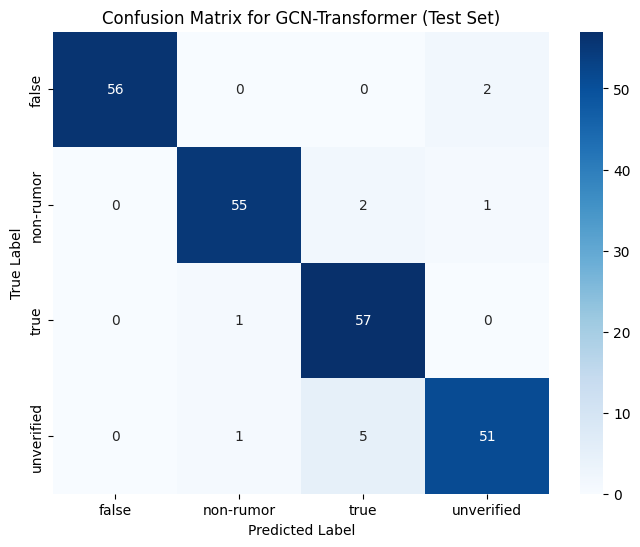

In [124]:
# Convert numeric labels back to original text labels
test_true_names = label_encoder.inverse_transform(test_true.numpy())  
test_pred_names = label_encoder.inverse_transform(test_pred.numpy())  


print("Classification Report:\n")
print(classification_report(test_true_names, test_pred_names))


conf_matrix = confusion_matrix(test_true_names, test_pred_names)  # Compute confusion matrix
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for GCN-Transformer (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

<h2> References </h2>


- https://github.com/OwenLeng/rumor-detection-include-twitter15-twitter16data-/blob/master/model/GAT.py
- https://arxiv.org/pdf/2012.09699v2
- https://medium.com/the-dl/transformers-viewed-as-generalizations-of-gcns-afe3b595c903
- https://arxiv.org/html/2401.06436v1
- https://github.com/deepfindr/gnn-project/blob/main/model.py
- https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html
- https://github.com/pytergeist/GCN-Transformer-Network/tree/main/src/layers
- https://link.springer.com/article/10.1007/s44196-023-00337-z